## 基础 multi-label 模型的表现

### models

In [1]:
import skmultilearn
from leemultilearn.dataset import available_datasets, load_dataset
import numpy as np
import leemultilearn

`BinaryRelevance`: use Support Vector Classifier as base classifier

In [2]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from leemultilearn.utils.convert import to_ndarray

class RidgeClf_mini(RidgeClassifier):
    def predict_proba(self, X):
        return self.decision_function(X)

class RidgeClf_full:
    def __init__(self, *, alpha=0.1):
        self.alpha = alpha
    
    def _feature_expansion(self, X):
        X = to_ndarray(X)
        X = np.hstack([X, np.ones((n, 1))])
    
    def fit(self, X, y):
        X = to_ndarray(X)
        y = to_ndarray(y)
        n, m = X.shape
        _, q = y.shape
        X = np.hstack([X, np.ones((n, 1))])
        
        self.W = np.linalg.inv(X.T @ X + self.alpha * np.eye(m + 1)) @ (X.T @ y)
    
    def predict_proba(self, X):
        X = to_ndarray(X)
        n, m = X.shape
        X = np.hstack([X, np.ones((n, 1))])
        return X @ self.W
    
    def predict(self, X):
        X = to_ndarray(X)
        n, m = X.shape
        X = np.hstack([X, np.ones((n, 1))])
        return X @ self.W > 0.5

`RidgeClassfier`: Linear least squares with l2 regularization, minimize $\ ||y - Xw||^2_2 + \alpha ||w||^2_2$

`MLPClassfier`: Multi-layer Perception With Sigmoid and BCE loss

### Multi-layer Perception With BCE loss

In [28]:
from leemultilearn.models import MLPClassifier
MLP_mini = lambda: MLPClassifier(
    max_iter=1000,
    hidden_layer_sizes=[],
    loss='binary_log_loss',
    out_activation_='logistic',
)

`ML-kNN`: lazy learning approach

### ML-$k$NN 

In [30]:
from leemultilearn.models import MLkNN

### dataset

In [31]:
def print_mll_datasets_info(dataset_names):    
    print(f"{'name':<20s} {'N':<6s} {'M':<6s} {'Q':<6s}")
    print("-" * 41)
    for name in dataset_names:
        X, Y, _, _ = leemultilearn.dataset.load_dataset(name, 'undivided')
        n, m, q = X.shape[0], X.shape[1], Y.shape[1]
        print(f"{name:<20s} {n:<6d} {m:<6d} {q:<6d}")

In [32]:
datasets = {k for k, v in available_datasets()}
print_mll_datasets_info(datasets)

name                 N      M      Q     
-----------------------------------------
Birds                645    260    19    
Yahoo-Social         12111  52350  39    
Yahoo-Science        6428   37187  40    
scene                2407   294    6     
Yahoo-Reference      8027   39679  33    
Enron                1702   1001   53    
Yahoo-Business       11214  21924  30    
Emotions             593    72     6     
mediamill            43907  120    101   
rcv1subset1          6000   47236  101   
Yahoo-Computers      12444  34096  33    
tmc2007-500          28596  500    22    
tmc2007              28596  49060  22    
Yahoo-Arts           7484   23146  26    
Medical              978    1449   45    
Image                2000   294    5     
Corel5k              5000   499    374   
Yahoo-Society        14512  31802  27    
Bibtex               7395   1836   159   
Yahoo-Entertainment  12730  32001  21    
yeast                2417   103    14    
Slashdot             3782   1079  

In [20]:
from leemultilearn.metrics import (
    hamming_loss,
    label_ranking_loss,
    average_precision_score,
    coverage_error,
    one_error,
)
from scipy.sparse import issparse

In [21]:
def test_result(y_test, y_pred, y_pred_proba):
    y_test = y_test.toarray() if issparse(y_test) else y_test
    y_pred = y_pred.toarray() if issparse(y_pred) else y_pred
    y_pred_proba = y_pred_proba.toarray() if issparse(y_pred_proba) else y_pred_proba
    
    return (
        hamming_loss(y_test, y_pred), 
        label_ranking_loss(y_test, y_pred_proba), 
        coverage_error(y_test, y_pred_proba), 
        one_error(y_test, y_pred_proba), 
        average_precision_score(y_test, y_pred_proba), 
    )

In [22]:
def print_test_result(y_test, y_pred, y_pred_proba):
    hamming_loss, label_ranking_loss, coverage_error, one_error, average_precision_score = test_result(y_test, y_pred, y_pred_proba)
    
    print('%15s: %.4f' % ('hamming_loss', hamming_loss))
    print('%15s: %.4f' % ('ranking_loss', label_ranking_loss))
    print('%15s: %.4f' % ('coverage_error', coverage_error))
    print('%15s: %.4f' % ('one_error', one_error))
    print('%15s: %.4f' % ('avg_precision', average_precision_score))

### 测试

In [23]:
models = {
    'ridge_reg(mini)': RidgeClf_mini,
    'mlp(BCEloss)': MLP_mini,
    'ml_knn': MLkNN,
    # 'br(SVC)': model_br, 
    'ridge_reg(full)': lambda: RidgeClassifier2(alpha=0.1)
}

NameError: name 'ML' is not defined

In [24]:
import time
from leemultilearn.dataset import available_datasets, load_dataset

In [25]:
result = dict()

for dataset_name in ['Image', 'Emotions', 'scene', 'yeast', 'Birds', 'Enron']:
# for dataset_name in ['Birds', 'Yahoo-Social', 'Enron', 'rcv1subset1', 'Bibtex']:
    print(dataset_name)
    X_train, Y_train, _, _ = load_dataset(dataset_name, 'train')
    X_test,  Y_test,  _, _ = load_dataset(dataset_name, 'test')
    
    for model_name, model_initializer in models.items():
        print(f"- {model_name} training ...", end=" ")
        
        time_begin = time.time()
        
        model = model_initializer()
        model.fit(X_train, Y_train)
        
        Y_pred       = model.predict(X_test)
        Y_pred_proba = model.predict_proba(X_test)
        
        time_end = time.time()
        time_cost = time_end - time_begin
        
        result[(dataset_name, model_name)] = (Y_test, Y_pred, Y_pred_proba)
        print(f"done ({time_cost:.2f}s)")

Image


NameError: name 'models' is not defined

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
result2 = dict()
print(f'{"dataset":15s} {"model":20s}', end='')
print(('{:12s} ' * 5).format("hamming_loss", "ranking_loss", "coverage_err", "one_err", "avg_precision"))
print('-' * 100)

for (dataset_name, model_name), (Y_test, Y_pred, Y_pred_proba) in result.items():
    print(f'{dataset_name:15s} {model_name:20s}', end='')
    print(('{:<12.4f} ' * 5).format(*test_result(Y_test, Y_pred, Y_pred_proba)))

dataset         model               hamming_loss ranking_loss coverage_err one_err      avg_precision 
----------------------------------------------------------------------------------------------------
Image           ridge_reg(mini)     0.1808       0.1953       0.4124       0.3520       0.6299       
Image           ridge_reg(full)     0.1820       0.1947       0.4120       0.3500       0.6298       
Emotions        ridge_reg(mini)     0.2219       0.1890       0.5025       0.2822       0.6920       
Emotions        ridge_reg(full)     0.2203       0.1873       0.5017       0.2822       0.6915       
scene           ridge_reg(mini)     0.1267       0.1354       0.2984       0.3420       0.6495       
scene           ridge_reg(full)     0.1268       0.1358       0.2988       0.3420       0.6496       
yeast           ridge_reg(mini)     0.2030       0.1832       0.5480       0.2366       0.4544       
yeast           ridge_reg(full)     0.2030       0.1832       0.5481       0.2366 

`ridge_reg(mini)` 和 `ridge_reg(full)` 的结果是一致的

### 数据记录


```
dataset         model          hamming_loss ranking_loss coverage_err one_err      avg_precision 
----------------------------------------------------------------------------------------------------
Image           ridge_reg      0.1808       0.1953       0.4124       0.3520       0.4820       
Image           mlp(BCEloss)   0.1748       0.1683       0.3924       0.3080       0.4986       
Image           ml_knn         0.1868       0.1895       0.4068       0.3380       0.4802       
Image           br(SVC)        0.1864       0.1475       0.3772       0.2740       0.4369  
-----------------------------------------------------------------------------------------
Emotions        ridge_reg      0.2219       0.1890       0.5025       0.2822       0.5495       
Emotions        mlp(BCEloss)   0.2252       0.1769       0.4893       0.2871       0.5406       
Emotions        ml_knn         0.3036       0.2809       0.5734       0.4307       0.4140       
Emotions        br(SVC)        0.3251       0.2524       0.5619       0.4257       0.3325
-----------------------------------------------------------------------------------------
scene           ridge_reg      0.1267       0.1354       0.2984       0.3420       0.4748       
scene           mlp(BCEloss)   0.1073       0.0897       0.2582       0.2567       0.5518       
scene           ml_knn         0.0900       0.0939       0.2620       0.2349       0.6054       
scene           br(SVC)        0.0842       0.0628       0.2355       0.1931       0.6295
-----------------------------------------------------------------------------------------
yeast           ridge_reg      0.2030       0.1832       0.5480       0.2366       0.3644       
yeast           mlp(BCEloss)   0.2045       0.1811       0.5435       0.2497       0.3691       
yeast           ml_knn         0.2092       0.1806       0.5400       0.2519       0.3734       
yeast           br(SVC)        0.1866       0.1600       0.5189       0.2356       0.3869
```

看起来四个基础模型都差不太多，
师兄虽然跟我说用 BCE loss 效果特别好，
但在这些 multi-label learning 数据集上没看出来 (抱歉). 

`br(SVC)` 因为没有并行所以需要 q 个模型分别训练，特别慢. 

```
dataset         model          hamming_loss ranking_loss coverage_err one_err      avg_precision 
----------------------------------------------------------------------------------------------------
Birds           ridge_reg      0.0556       0.1042       0.1874       0.6966       0.1428       
Birds           mlp(BCEloss)   0.0565       0.1993       0.2953       0.8328       0.0839       
Birds           ml_knn         0.0538       0.1690       0.2496       0.8824       0.0524
-----------------------------------------------------------------------------------------
Yahoo-Social    ridge_reg      0.0629       0.1891       0.2554       0.4697       0.0669       
Yahoo-Social    mlp(BCEloss)   0.0199       0.0464       0.0948       0.2502       0.1525       
Yahoo-Social    ml_knn         0.0230       0.0614       0.1076       0.3398       0.1201
-----------------------------------------------------------------------------------------
Enron           ridge_reg      0.0824       0.2049       0.3796       0.6542       0.3927       
Enron           mlp(BCEloss)   0.0441       0.1358       0.2974       0.5989       0.5617       
Enron           ml_knn         0.0512       0.1375       0.2932       0.6756       0.4620
-----------------------------------------------------------------------------------------
rcv1subset1     ridge_reg      0.0412       0.4246       0.6566       0.8763       0.0600       
rcv1subset1     mlp(BCEloss)   0.0406       0.4033       0.6278       0.8673       0.0550       
rcv1subset1     ml_knn         0.0434       0.4352       0.6443       0.8937       0.0592
-----------------------------------------------------------------------------------------
Bibtex          ridge_reg      0.0127       0.1200       0.2347       0.3650       0.1420
Bibtex          mlp(BCEloss)   0.0142       0.1112       0.2066       0.4358       0.1508       
Bibtex          ml_knn         0.0151       0.2576       0.4097       0.5956       0.0710       
```

看起来在更大的数据集上面这些模型的表现还有很大很大提升空间，
毕竟 `avg_precision` 太低而 `one_err` 太高了. 

## 偏多标记测试

In [21]:
from leemultilearn.pml_dataset import available_datasets, load_dataset

In [ ]:
result = dict()

for dataset_name in {k for k, v in available_datasets()}:
    print(dataset_name)
    X_train, _,      Yc_train = load_dataset(dataset_name, 'train')
    X_test,  Y_test, _        = load_dataset(dataset_name, 'test')
    
    for model_name, model_initializer in models.items():
        print(f"- {model_name} training ...", end=" ")
        
        time_begin = time.time()
        
        model = model_initializer()
        model.fit(X_train, Yc_train)
        
        Y_pred       = model.predict(X_test)
        Y_pred_proba = model.predict_proba(X_test)
        
        time_end = time.time()
        time_cost = time_end - time_begin
        
        result[(dataset_name, model_name)] = (Y_test, Y_pred, Y_pred_proba)
        print(f"done ({time_cost:.2f}s)")

YeastMF
- ridge_reg training ... done (1.76s)
- ridge_reg2 training ... 

In [99]:
result2 = dict()
print(f'{"dataset":15s} {"model":15s}', end='')
print(('{:12s} ' * 5).format("hamming_loss", "ranking_loss", "coverage_err", "one_err", "avg_precision"))
print('-' * 100)

for (dataset_name, model_name), (Y_test, Y_pred, Y_pred_proba) in result.items():
    print(f'{dataset_name:15s} {model_name:15s}', end='')
    print(('{:<12.4f} ' * 5).format(*test_result(Y_test, Y_pred, Y_pred_proba)))

dataset         model          hamming_loss ranking_loss coverage_err one_err      avg_precision 
----------------------------------------------------------------------------------------------------
YeastMF         ridge_reg2     0.1135       0.1544       0.1969       0.9235       0.0822       
mirflickr       ridge_reg2     0.2160       0.1480       0.3933       0.3102       0.5689       
music_style     ridge_reg2     0.7114       0.1472       0.3059       0.3562       0.3443       
YeastCC         ridge_reg2     0.1054       0.1299       0.1897       0.8740       0.1399       
music_emotion   ridge_reg2     0.3286       0.2552       0.5099       0.4951       0.4146       
YeastBP         ridge_reg2     0.0984       0.2370       0.4016       0.8534       0.1291       


### 数据记录

```
dataset         model          hamming_loss ranking_loss coverage_err one_err      avg_precision 
----------------------------------------------------------------------------------------------------
YeastMF         ridge_reg      0.1135       0.1544       0.1969       0.9235       0.0427       
YeastMF         mlp(BCEloss)   0.0274       0.0932       0.1321       0.8393       0.0948       
YeastMF         ml_knn         0.0269       0.1493       0.1940       0.9273       0.0486
-----------------------------------------------------------------------------------------
mirflickr       ridge_reg      0.2160       0.1480       0.3933       0.3102       0.4151       
mirflickr       mlp(BCEloss)   0.2178       0.1071       0.3604       0.2633       0.4187       
mirflickr       ml_knn         0.2237       0.1371       0.3985       0.2032       0.4084
-----------------------------------------------------------------------------------------
music_style     ridge_reg      0.7114       0.1472       0.3059       0.3562       0.1545       
music_style     mlp(BCEloss)   0.4646       0.6461       0.7477       0.9479       0.1434       
music_style     ml_knn         0.6358       0.2939       0.4493       0.5658       0.1460
-----------------------------------------------------------------------------------------
YeastCC         ridge_reg      0.1054       0.1299       0.1897       0.8740       0.0657       
YeastCC         mlp(BCEloss)   0.0260       0.0653       0.1149       0.7736       0.1927       
YeastCC         ml_knn         0.0281       0.1273       0.1905       0.8599       0.1122
-----------------------------------------------------------------------------------------
music_emotion   ridge_reg      0.3286       0.2552       0.5099       0.4951       0.2932       
music_emotion   mlp(BCEloss)   0.4474       0.6719       0.8665       0.7541       0.2210       
music_emotion   ml_knn         0.4187       0.3955       0.6509       0.6254       0.2241
-----------------------------------------------------------------------------------------
YeastBP         ridge_reg      0.0984       0.2370       0.4016       0.8534       0.0591       
YeastBP         mlp(BCEloss)   0.0269       0.1460       0.2843       0.7139       0.1473       
YeastBP         ml_knn         0.0265       0.2375       0.3978       0.8252       0.1027     
```

In [88]:
Y_test, Y_pred, Y_pred_proba = result[('mirflickr', 'ridge_reg')]

In [85]:
Y_test.mean()

0.02575591547956789

## mixup

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import random
from leemultilearn.utils.convert import to_ndarray

In [33]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [43]:
from leemultilearn.dataset import load_dataset

class MllDataset(Dataset):
    def __init__(self, name, divide):
        X, Y, _, _ = load_dataset(name, divide)
        self.X = X
        self.Y = Y
        self.num_samples = X.shape[0]
        self.dim_features = X.shape[1]
        self.dim_labels = Y.shape[1]
        
    def __getitem__(self, index):
        return to_ndarray(self.X[index, :]), to_ndarray(self.Y[index, :])
        
    def __len__(self):
        return self.num_samples

In [194]:
train_dataset = MllDataset(name='Scene', divide='train')
test_dataset = MllDataset(name='Scene', divide='test')
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=True
)

In [125]:
class MlpNet(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden_layer_sizes=[]):
        super(MlpNet, self).__init__()
        
        sizes = [in_features] + list(hidden_layer_sizes) + [out_features]
        
        sequential = []
        sequential.append(torch.nn.Flatten())
        sequential.append(torch.nn.Linear(sizes[0], sizes[1], bias=True))
        for in_, out_ in zip(sizes[1:-1], sizes[2:]):
            sequential.append(torch.nn.ReLU(inplace=True))
            sequential.append(torch.nn.Linear(in_, out_, bias=True))
        sequential.append(nn.Sigmoid())
        
        self.sequential = nn.Sequential(*sequential)
            
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.sequential(x)
        return x

In [166]:
def train(model, dataloader, criterion, optimizer, epochs=5, verbose=True):
    model.train()
    for epoch in range(epochs):
        
        epoch_loss = 0.0
        
        for X, Y in dataloader:
            Y = Y.squeeze().to(torch.float32)
            
            # # Mixup inputs.
            # lambda_ = np.random.beta(alpha, alpha)
            # idxs = torch.randperm(X.size(0))
            # mixed_X = lambda_ * X + (1 - lambda_) * X[idxs, :]
            # 
            # # Mixup loss.    
            # Y_pred = model(X)
            # loss = lambda_ * criterion(Y_pred, Y) + (1 - lambda_) * criterion(Y_pred, Y[idxs, :])
            
            # no Mixup
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += loss.item()
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f'epoch={epoch:<2d}, loss={epoch_loss:<8.2f}')

In [180]:
def train_with_mixup(model, dataloader, criterion, optimizer, epochs=5, alpha=0.2, verbose=True):
    model.train()
    for epoch in range(epochs):
        
        epoch_loss = 0.0
        
        for X, Y in dataloader:
            Y = Y.squeeze().to(torch.float32)
            
            # Mixup inputs.
            lambda_ = np.random.beta(alpha, alpha)
            idxs = torch.randperm(X.size(0))
            mixed_X = lambda_ * X + (1 - lambda_) * X[idxs, :]
            
            # Mixup loss.    
            Y_pred = model(X)
            loss = lambda_ * criterion(Y_pred, Y) + (1 - lambda_) * criterion(Y_pred, Y[idxs, :])
            
            # # no Mixup
            # Y_pred = model(X)
            # loss = criterion(Y_pred, Y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss += loss.item()
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f'epoch={epoch:<2d}, loss={epoch_loss:<8.2f}')

In [168]:
def test(model, dataloader):
    model.eval()
    X_test, Y_test = next(iter(test_dataloader))
    Y_test = Y_test.squeeze().numpy()
    # no Mixup
    Y_pred_proba = model(X_test).detach().squeeze().numpy()
    Y_pred = Y_pred_proba > 0.5
    
    print_test_result(Y_test, Y_pred, Y_pred_proba)

### model without mixup

In [193]:
model = MlpNet(
    in_features=train_dataset.dim_features, 
    out_features=train_dataset.dim_labels
)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

In [179]:
train(model, train_dataloader, criterion, optimizer, epochs=100)

epoch=9 , loss=5.01    
epoch=19, loss=4.55    
epoch=29, loss=4.30    
epoch=39, loss=4.14    
epoch=49, loss=4.04    
epoch=59, loss=3.93    
epoch=69, loss=3.83    
epoch=79, loss=3.77    
epoch=89, loss=3.70    
epoch=99, loss=3.67    


In [181]:
test(model, test_dataloader)

   hamming_loss: 0.0938
   ranking_loss: 0.0805
 coverage_error: 0.2474
      one_error: 0.2500
  avg_precision: 0.8148


In [182]:
train(model, train_dataloader, criterion, optimizer, epochs=100)

epoch=9 , loss=3.62    
epoch=19, loss=3.56    
epoch=29, loss=3.53    
epoch=39, loss=3.47    
epoch=49, loss=3.47    
epoch=59, loss=3.41    
epoch=69, loss=3.38    
epoch=79, loss=3.36    
epoch=89, loss=3.33    
epoch=99, loss=3.30    


In [183]:
test(model, test_dataloader)

   hamming_loss: 0.0833
   ranking_loss: 0.0488
 coverage_error: 0.2161
      one_error: 0.2031
  avg_precision: 0.7743


In [184]:
train(model, train_dataloader, criterion, optimizer, epochs=100)

epoch=9 , loss=3.28    
epoch=19, loss=3.24    
epoch=29, loss=3.21    
epoch=39, loss=3.19    
epoch=49, loss=3.18    
epoch=59, loss=3.16    
epoch=69, loss=3.14    
epoch=79, loss=3.12    
epoch=89, loss=3.12    
epoch=99, loss=3.10    


In [185]:
test(model, test_dataloader)

   hamming_loss: 0.0964
   ranking_loss: 0.0930
 coverage_error: 0.2682
      one_error: 0.2656
  avg_precision: 0.7530


### model with mixup

In [186]:
model2 = MlpNet(in_features=294, out_features=6)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=1.0)

In [187]:
train_with_mixup(model2, train_dataloader, criterion, optimizer, epochs=100, alpha=0.2)

epoch=9 , loss=8.59    
epoch=19, loss=7.86    
epoch=29, loss=7.98    
epoch=39, loss=7.85    
epoch=49, loss=7.67    
epoch=59, loss=7.68    
epoch=69, loss=7.73    
epoch=79, loss=7.51    
epoch=89, loss=7.31    
epoch=99, loss=7.95    


In [188]:
test(model, test_dataloader)

   hamming_loss: 0.0911
   ranking_loss: 0.0730
 coverage_error: 0.2500
      one_error: 0.2031
  avg_precision: 0.7782


In [189]:
train_with_mixup(model2, train_dataloader, criterion, optimizer, epochs=100, alpha=0.2)

epoch=9 , loss=8.13    
epoch=19, loss=7.42    
epoch=29, loss=8.58    
epoch=39, loss=7.86    
epoch=49, loss=7.92    
epoch=59, loss=6.78    
epoch=69, loss=7.74    
epoch=79, loss=8.07    
epoch=89, loss=7.58    
epoch=99, loss=7.55    


In [190]:
test(model, test_dataloader)

   hamming_loss: 0.0990
   ranking_loss: 0.1059
 coverage_error: 0.2734
      one_error: 0.2656
  avg_precision: 0.7764


In [191]:
train_with_mixup(model2, train_dataloader, criterion, optimizer, epochs=100, alpha=0.2)

epoch=9 , loss=7.78    
epoch=19, loss=7.61    
epoch=29, loss=8.11    
epoch=39, loss=7.64    
epoch=49, loss=8.27    
epoch=59, loss=7.31    
epoch=69, loss=7.88    
epoch=79, loss=7.76    
epoch=89, loss=7.92    
epoch=99, loss=7.40    


In [74]:
# criterion = nn.CrossEntropyLoss()
# for x, y in train_loader:
#     x, y = x.cuda(), y.cuda()
#     # Mixup inputs.
#     lam = np.random.beta(alpha, alpha)
#     index = torch.randperm(x.size(0)).cuda()
#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     # Mixup loss.    
#     pred = model(mixed_x)
#     loss = lam * criterion(pred, y) + (1 - lam) * criterion(pred, y[index])
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()


NameError: name 'nn' is not defined

### test on different dataset

In [197]:
def test_on_dataset(dataset_name):
    train_dataset = MllDataset(name=dataset_name, divide='train')
    test_dataset = MllDataset(name=dataset_name, divide='test')
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    
    criterion = nn.BCELoss()
    
    model_without_mixup = MlpNet(
        in_features=train_dataset.dim_features, 
        out_features=train_dataset.dim_labels
    )
    optimizer_without_mixup = torch.optim.SGD(model_without_mixup.parameters(), lr=0.1)
    
    train(model_without_mixup, train_dataloader, criterion, optimizer_without_mixup, epochs=200)
    test(model_without_mixup, test_dataloader)
    
    model_with_mixup = MlpNet(
        in_features=train_dataset.dim_features, 
        out_features=train_dataset.dim_labels
    )
    optimizer_with_mixup = torch.optim.SGD(model_with_mixup.parameters(), lr=0.1)
    
    train_with_mixup(model_with_mixup, train_dataloader, criterion, optimizer_with_mixup, epochs=200)
    test(model_with_mixup, test_dataloader)   
    

In [198]:
test_on_dataset('Scene')

epoch=9 , loss=7.18    
epoch=19, loss=6.38    
epoch=29, loss=5.94    
epoch=39, loss=5.66    
epoch=49, loss=5.45    
epoch=59, loss=5.30    
epoch=69, loss=5.17    
epoch=79, loss=5.07    
epoch=89, loss=4.98    
epoch=99, loss=4.91    
epoch=109, loss=4.84    
epoch=119, loss=4.78    
epoch=129, loss=4.73    
epoch=139, loss=4.68    
epoch=149, loss=4.63    
epoch=159, loss=4.60    
epoch=169, loss=4.56    
epoch=179, loss=4.52    
epoch=189, loss=4.49    
epoch=199, loss=4.46    
   hamming_loss: 0.0938
   ranking_loss: 0.0875
 coverage_error: 0.2474
      one_error: 0.2812
  avg_precision: 0.8028
epoch=9 , loss=8.47    
epoch=19, loss=8.28    
epoch=29, loss=8.24    
epoch=39, loss=8.08    
epoch=49, loss=7.82    
epoch=59, loss=7.67    
epoch=69, loss=7.23    
epoch=79, loss=7.83    
epoch=89, loss=7.95    
epoch=99, loss=8.18    
epoch=109, loss=8.26    
epoch=119, loss=8.02    
epoch=129, loss=8.04    
epoch=139, loss=9.05    
epoch=149, loss=7.77    
epoch=159, loss=7.72    


```
 model             loss     no-mixup   mixup
---------------------------------------------
           hamming_loss     0.0833     0.0911
           ranking_loss     0.0488     0.0730
 MLP     coverage_error     0.2161     0.2500
              one_error     0.2031     0.2031
          avg_precision     0.7743     0.7782
---------------------------------------------
           hamming_loss     0.1172     0.1536
           ranking_loss     0.0875     0.1512
 MLP     coverage_error     0.2656     0.2995
              one_error     0.2656     0.3906
          avg_precision     0.7508     0.7200
```

## 区分 clean samples & noisy samples

### init

In [200]:
from leemultilearn.pml_dataset import load_dataset

class PmlDataset(Dataset):
    def __init__(self, name, divide):
        X, Y, Yc = load_dataset(name, divide)
        self.X  = X
        self.Y  = Y
        self.Yc = Yc
        self.num_samples = X.shape[0]
        self.dim_features = X.shape[1]
        self.dim_labels = Y.shape[1]
        
    def __getitem__(self, index):
        return to_ndarray(self.X[index, :]), to_ndarray(self.Y[index, :]), to_ndarray(self.Yc[index, :])
        
    def __len__(self):
        return self.num_samples

In [203]:
train_dataset = PmlDataset(name='mirflickr', divide='train')
test_dataset = PmlDataset(name='mirflickr', divide='test')
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False
)

### train

In [240]:
model = MlpNet(in_features=train_dataset.dim_features, out_features=train_dataset.dim_labels)
criterion = nn.BCELoss()
criterion_keep_dims = nn.BCELoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

In [241]:
model.train()
epoch_loss_mat_records = []
epoch_loss_records = []
for epoch in range(100):

    epoch_loss = 0.0
    epoch_loss_mat = np.zeros((0, train_dataset.dim_labels))

    for X, _, Yc in train_dataloader:
        Yc = Yc.squeeze().to(torch.float32)

        # no Mixup
        Y_pred = model(X)
        loss = criterion(Y_pred, Yc)
        loss_keep_dims = criterion_keep_dims(Y_pred, Yc)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        epoch_loss_mat = np.vstack([epoch_loss_mat, loss_keep_dims.detach().numpy()])

    print(f'epoch={epoch:<2d}, loss={epoch_loss:<8.2f}')
    
    epoch_loss_mat_records.append(epoch_loss_mat)

epoch=0 , loss=35.61   
epoch=1 , loss=27.16   
epoch=2 , loss=26.08   
epoch=3 , loss=25.65   
epoch=4 , loss=25.41   
epoch=5 , loss=25.27   
epoch=6 , loss=25.16   
epoch=7 , loss=25.09   
epoch=8 , loss=25.03   
epoch=9 , loss=24.98   
epoch=10, loss=24.94   
epoch=11, loss=24.91   
epoch=12, loss=24.89   
epoch=13, loss=24.86   
epoch=14, loss=24.84   
epoch=15, loss=24.83   
epoch=16, loss=24.81   
epoch=17, loss=24.80   
epoch=18, loss=24.78   
epoch=19, loss=24.77   
epoch=20, loss=24.76   
epoch=21, loss=24.75   
epoch=22, loss=24.75   
epoch=23, loss=24.74   
epoch=24, loss=24.73   
epoch=25, loss=24.73   
epoch=26, loss=24.72   
epoch=27, loss=24.71   
epoch=28, loss=24.71   
epoch=29, loss=24.71   
epoch=30, loss=24.70   
epoch=31, loss=24.70   
epoch=32, loss=24.69   
epoch=33, loss=24.69   
epoch=34, loss=24.69   
epoch=35, loss=24.68   
epoch=36, loss=24.68   
epoch=37, loss=24.68   
epoch=38, loss=24.68   
epoch=39, loss=24.68   
epoch=40, loss=24.67   
epoch=41, loss=2

In [242]:
epoch_loss_mat_records[0].shape

(7303, 7)

In [243]:
X, Y, Yc = load_dataset('mirflickr', 'train')

In [250]:
clean_label_filter = (Y == 1)
noisy_label_filter = ((Y == 0) & (Yc == 1))
none_label_filter = (Yc == 0)

In [254]:
Y[Y.nonzero()]

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [261]:
epoch_clean_loss_records = [
    (l[clean_label_filter][l[clean_label_filter].nonzero()].mean(), 
     l[clean_label_filter][l[clean_label_filter].nonzero()].std())
    for l in epoch_loss_mat_records
]
epoch_noisy_loss_records = [
    (l[noisy_label_filter][l[noisy_label_filter].nonzero()].mean(),
     l[noisy_label_filter][l[noisy_label_filter].nonzero()].std())
    for l in epoch_loss_mat_records
]
epoch_none_loss_records = [
    (l[none_label_filter][l[none_label_filter].nonzero()].mean(),
     l[none_label_filter][l[none_label_filter].nonzero()].std())
    for l in epoch_loss_mat_records
]

### test

In [299]:
model.eval()
for X, Y, Yc in train_dataloader:
    Y = Y.squeeze().to(torch.float32)

    # no Mixup
    Y_pred = model(X).detach()
    # loss = criterion(Y_pred, Y)
    # loss_keep_dims = criterion_keep_dims(Y_pred, Yc)
    print_test_result(Y.numpy(), Y_pred.numpy() > 0.5, Y_pred.numpy())
    
    break

   hamming_loss: 0.2411
   ranking_loss: 0.1479
 coverage_error: 0.3795
      one_error: 0.3906
  avg_precision: 0.6402


### plot

In [258]:
from matplotlib import pyplot as plt

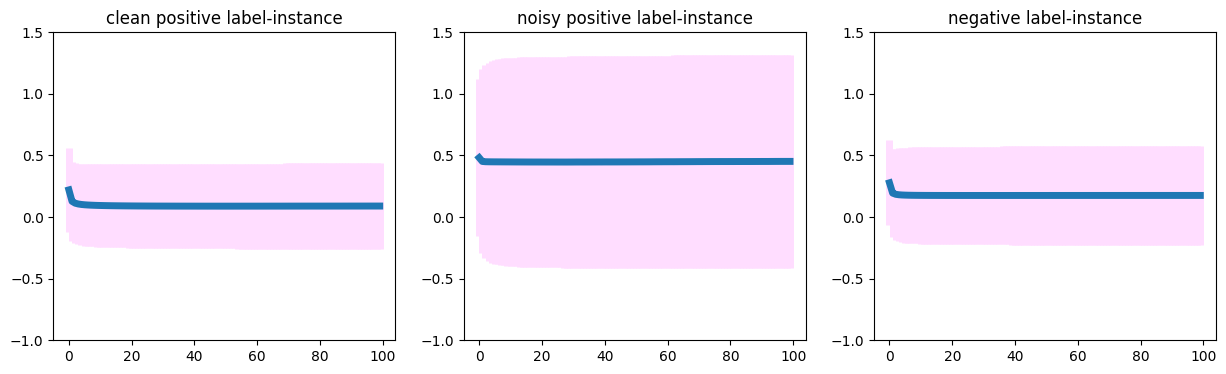

In [308]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
plt.errorbar(
    x=np.arange(len(epoch_clean_loss_records)),
    y=[e1 for e1, e2 in epoch_clean_loss_records], 
    yerr=[e2 for e1, e2 in epoch_clean_loss_records],
    linewidth=5,
    ecolor='#FDF',
    elinewidth=5,
    label='clean positive label-instance',
)
plt.ylim(-1.00, 1.5)
# plt.legend()
plt.title('clean positive label-instance')

plt.subplot(1, 3, 2)
plt.errorbar(
    x=np.arange(len(epoch_noisy_loss_records)),
    y=[e1 for e1, e2 in epoch_noisy_loss_records], 
    yerr=[e2 for e1, e2 in epoch_noisy_loss_records],
    linewidth=5,
    ecolor='#FDF',
    elinewidth=5,
    label='noisy positive label-instance',
)
plt.ylim(-1.00, 1.5)
# plt.legend()
plt.title('noisy positive label-instance')

plt.subplot(1, 3, 3)
plt.errorbar(
    x=np.arange(len(epoch_none_loss_records)),
    y=[e1 for e1, e2 in epoch_none_loss_records], 
    yerr=[e2 for e1, e2 in epoch_none_loss_records],
    linewidth=5,
    ecolor='#FDF',
    elinewidth=5,
    label='negative label-instance',
)
plt.ylim(-1.0, 1.5)
# plt.legend()
plt.title('negative label-instance')


plt.show()

plt.show()

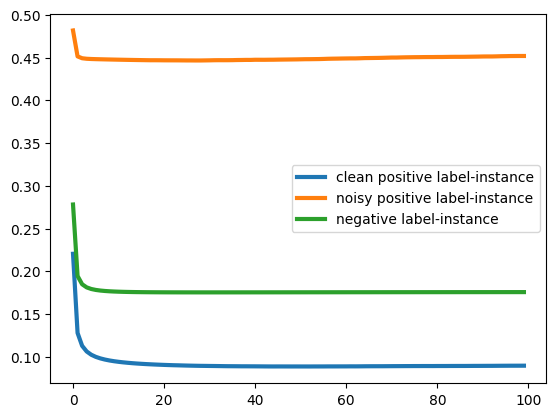

In [307]:
plt.plot([e1 for e1, e2 in epoch_clean_loss_records], label='clean positive label-instance', linewidth=3)
plt.plot([e1 for e1, e2 in epoch_noisy_loss_records], label='noisy positive label-instance', linewidth=3)
plt.plot([e1 for e1, e2 in epoch_none_loss_records], label='negative label-instance', linewidth=3)
plt.legend()
plt.show()